In [1]:
#This notebook is a walkthrough of the major pieces involved in the HMM data labeling step. It demonstrates how to label a 
#single example sentence with an HMM. "Labeling" means inferring when each character begins in the data, and using this
#information to construct output targets for supervised RNN training.

#Note that the complete data labeling procedure involves iteratively updating the HMM based on data from all available 
#sentences in a session. See Step2_hmmDataLabeling_automated for a complete implementation that can be run to label all
#sentences from all sessions.

In [2]:
import numpy as np
import scipy.io
import scipy.ndimage.filters
import os
import matplotlib.pyplot as plt
import sklearn.decomposition 
from characterDefinitions import getHandwritingCharacterDefinitions

#point this towards the top level dataset directory
rootDir = os.path.expanduser('~') + '/Documents/handwritingBCIData/'

#define which dataset to use as an example (and which sentence to use from that dataset)
dataDir = 't5.2019.05.08'
sentenceIdx = 15

#load sentences, single letter, and time-warped files
dat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/sentences.mat')
singleLetterDat = scipy.io.loadmat(rootDir+'Datasets/'+dataDir+'/singleLetters.mat')
twCubes = scipy.io.loadmat(rootDir+'RNNTrainingSteps/Step1_TimeWarping/'+dataDir+'_warpedCubes.mat')

#defines the list of all 31 characters and what to call them
charDef = getHandwritingCharacterDefinitions()

In [3]:
#Take a look at the example sentence (note that '>' denotes a space and '~' a period).
sentence = dat['sentencePrompt'][sentenceIdx,0][0]

print('Example sentence:')
print(sentence)

Example sentence:
so>far,>i>haven't>had>a>lot>of>luck>with>that~


In [4]:
#First, we make spatiotemporal 'templates' of neural activity for each character. 
#The templates will be used to initialize the HMM parameters.

#Make a template for each character and store it in the 'templates' dictionary
templates = {}
for char, charAbbr, thisCharLen in zip(charDef['charList'], charDef['charListAbbr'], charDef['charLen']):
    #Average the time-warped data across trials and smooth it
    neuralCube = twCubes[char].copy()
    neuralCube = np.nanmean(neuralCube, axis=0)
    neuralCube = scipy.ndimage.filters.gaussian_filter1d(neuralCube, 4.0, axis=0)
    
    #Select the time window of neural activity to use for this template (time step 50 is the 'go' cue)
    neuralCube = neuralCube[59:(59+thisCharLen+1),:]
    
    #Use PCA to denoise this template by keeping only the top 10 dimensions
    pcaModel = sklearn.decomposition.PCA(n_components=10)
    pcaModel.fit(neuralCube)
    lowRankTemplate = pcaModel.inverse_transform(pcaModel.transform(neuralCube))
    
    templates[charAbbr] = lowRankTemplate

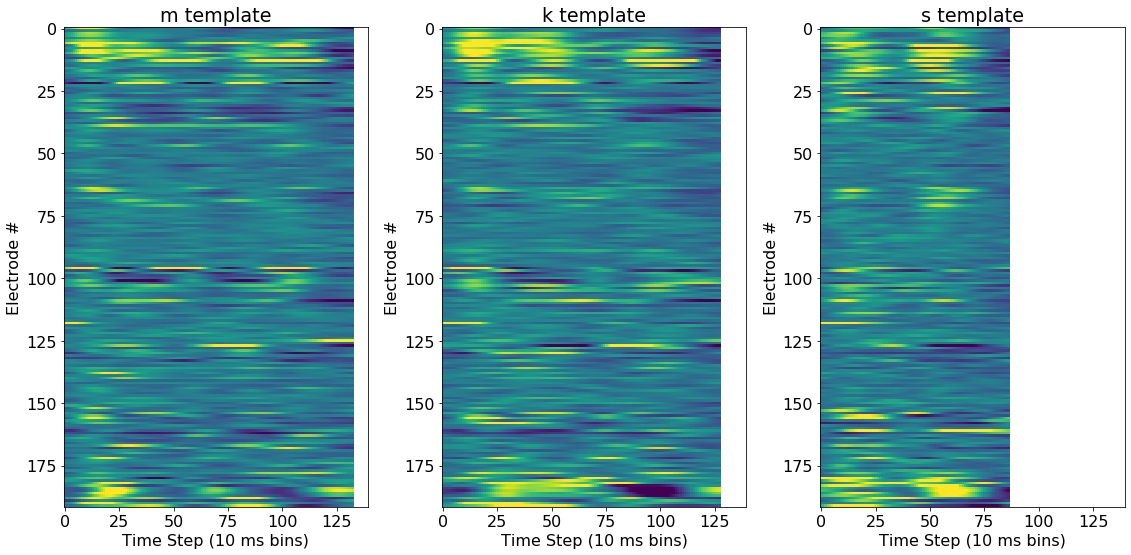

In [5]:
#Visualize the template activity patterns for a few example characters.
#Each pixel (i,j) in the images denotes the mean firing rate observed on electrode i during time step j.
exampleChars = ['m','k','s']

plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(16,8))

for char, plotIdx in zip(exampleChars, range(len(exampleChars))):
    plt.subplot(1,3,plotIdx+1)
    
    #Equalize the size of each display template so that they display with the same aspect ratios.
    tmp = np.zeros([192, 140])
    tmp[:] = np.nan
    tmp[:,0:templates[char].shape[0]] = np.transpose(templates[char])

    plt.imshow(tmp,clim=[-0.4, 0.6],aspect='auto')
    
    plt.title(char + ' template')
    plt.xlabel('Time Step (10 ms bins)')
    plt.ylabel('Electrode #')
    
plt.gcf().tight_layout()
plt.show()

In [6]:
#Now we construct the HMM state transitions & emission probabilities for our example sentence.
#Each HMM state corresponds to a piece of a character in the sentence.

#To speed things up and conserve memory, the HMM runs on larger time bins of data than the 'raw' 10 ms time steps. 
#hmmBinSize defines the number of 10 ms bins in a single HMM time step
hmmBinSize = 5 

#The following parameters define state transition probabilities
blankProb = 0.1 #probability of entering a blank state at the end of a character
stayProb = 0.20 #probability of persisting in the same state
skipProb = 0.20 #probability of skipping two states ahead (instead of simply advancing to the next one)

#First, compute the total number of states in the HMM (nStates) and the state at which each letter begins (letterStartIdx)
nStates = 0
letterStartIdx = np.zeros(len(sentence))
for x in range(len(sentence)):
    letterStartIdx[x] = nStates
    nStates = nStates + np.floor(templates[sentence[x]].shape[0]/hmmBinSize) + 1 #+1 for blank state at the end of each character

nStates = (nStates + 1).astype(np.int32) #+1 for blank state at the beginning of the sentence

letterStartIdx += 1 #adjust letterStartIdx to account for the blank state at the beginning of the sentence
letterStartIdx = letterStartIdx.astype(np.int32)

#Next, define the state transitions and emission distributions.
#The A matrix defines the state transitions (entry [i,j] is the probability of moving from i->j).
#The B matrix defines the emission probabilities (by defining mean firing rates for each state). One row for each state.
A_hmm = np.zeros([nStates, nStates])
B_hmm = np.zeros([nStates, templates[sentence[0]].shape[1]]) 

#For each state, store which character it belongs to (stateLabels) and that character's position in the sentence (stateLabelsSeq)
stateLabels = np.zeros([nStates,1], dtype='str')
stateLabelsSeq = np.zeros([nStates,1])
nChars = len(templates)

#loop through each character in the sentence and add that character's states to the HMM
for x in range(len(sentence)):
    
    #nBins is the number of HMM states in this character
    nBins = np.floor(templates[sentence[x]].shape[0]/hmmBinSize).astype(np.int32)
    currentState = letterStartIdx[x]
    
    #idxInTemplate keeps track of where we are in the character template for each HMM state
    idxInTemplate = np.arange(0, hmmBinSize).astype(np.int32)

    #loop through each HMM state belonging to the current character
    for b in range(nBins):
        
        #define the mean firing rates for this state
        meanRates = np.mean(templates[sentence[x]][idxInTemplate,:], axis=0)
        B_hmm[currentState, :] = meanRates
        
        #define which character and position this state belongs to
        stateLabels[currentState] = sentence[x]
        stateLabelsSeq[currentState] = x
        
        #define transition probabilities for this state
        A_hmm[currentState, currentState] = stayProb

        if b<(nBins-1):
            #--prior to last state-- 
            if b<(nBins-2):
                #we can advance one state OR skip two states ahead
                A_hmm[currentState, currentState+1] = 1-stayProb-skipProb
                A_hmm[currentState, currentState+2] = skipProb
            else:
                #this is the second to last state, so no skipping two states ahead
                A_hmm[currentState, currentState+1] = 1-stayProb
        else:
            #--last state--
            #we can either transition to a blank state at the end of the character or go to the next character
            
            #special blank state
            A_hmm[currentState, currentState+1] = (1-stayProb)*blankProb
            A_hmm[currentState+1, currentState+1] = 0.5

            stateLabels[currentState+1] = '&' #blank symbol
            stateLabelsSeq[currentState+1] = -1

            #go to the next letter or end the sentence
            if x<(len(sentence)-1):
                #transition to next letter
                A_hmm[currentState, letterStartIdx[x+1]] = (1-stayProb)*(1-blankProb) #last letter state
                A_hmm[currentState+1, letterStartIdx[x+1]] = 0.5 #blank
            else:
                #end of the sentence
                A_hmm[currentState, currentState+1] = (1-stayProb)
                A_hmm[currentState+1, currentState+1] = 1.0 #stay in blank permanently (this is the end of the sentence)

        currentState += 1
        idxInTemplate += hmmBinSize

#define the beginning blank state
stateLabels[0] = '&'
stateLabelsSeq[0] = -1
                      
A_hmm[0,0] = 0.5
A_hmm[0,1] = 0.5

#fill in emission probabilities for all blank states
letterStates = stateLabelsSeq >= 0
blankStates = stateLabelsSeq ==-1
blankFiringRates = np.mean(B_hmm[letterStates[:,0],:],axis=0,keepdims=True)
                      
B_hmm[blankStates[:,0],:] = blankFiringRates
                      
#define the variance for each emission dimension (assuming multivariate normal distribution with diagonal covariance)
diagVariance = np.ones([1 ,B_hmm.shape[1]])

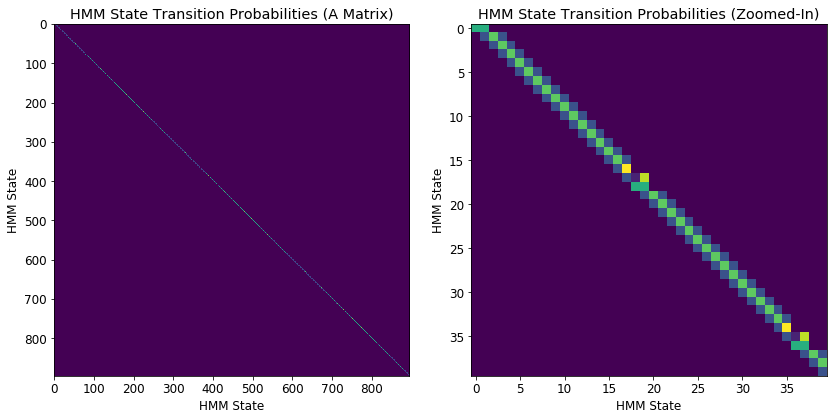

In [7]:
#Plot the state transition matrix for the HMM.
plt.rcParams.update({'font.size': 12})

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(A_hmm,aspect='auto')
plt.ylabel('HMM State')
plt.xlabel('HMM State')
plt.title('HMM State Transition Probabilities (A Matrix)')

plt.subplot(1,2,2)
plt.imshow(A_hmm[0:40,0:40],aspect='auto')
plt.ylabel('HMM State')
plt.xlabel('HMM State')
plt.title('HMM State Transition Probabilities (Zoomed-In)')

plt.gcf().tight_layout()
plt.show()

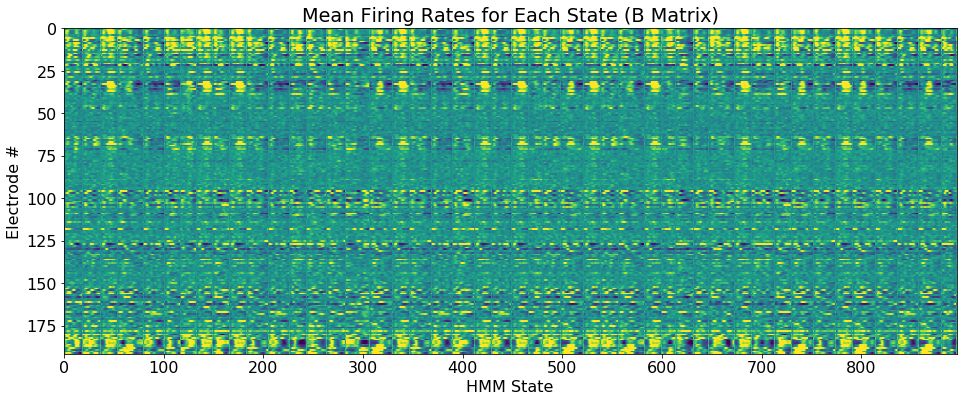

In [8]:
#Plot the mean firing rates for each state (B matrix).
#This matrix essentially express what the neural activity should look like for this sentence.

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(16,6))
plt.imshow(np.transpose(B_hmm),clim=[-0.5, 0.5],aspect='auto')
plt.ylabel('Electrode #')
plt.xlabel('HMM State')
plt.title('Mean Firing Rates for Each State (B Matrix)')
plt.show()

In [9]:
#The 'stateLabels' vector defines the character that each HMM state belongs to.
#We print it here, since it might be helpful to get a feel for how many states they are and how they map to characters.
#Note that '&' is a blank state.

print('State Character Labels')
print(np.transpose(stateLabels).tolist())

State Character Labels
[['&', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', 's', '&', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', '&', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '&', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', '&', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', '&', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'r', '&', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', ',', '&', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '&', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', 'i', '&', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '>', '&', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 'h', 

In [10]:
#Prepare the neural data to be processed by the HMM by normalizing, smoothing and binning it.
neuralCube = dat['neuralActivityCube'].astype(np.float64)

#subtract block-specific means from each trial 
#we use the means from the single letter data (since the templates also use this)
for b in range(dat['blockList'].shape[0]):
    trialsFromThisBlock = np.squeeze(dat['sentenceBlockNums']==dat['blockList'][b])
    trialsFromThisBlock = np.argwhere(trialsFromThisBlock)
        
    closestIdx = np.argmin(np.abs(singleLetterDat['blockList'].astype(np.int32) - dat['blockList'][b].astype(np.int32)))
    blockMeans = singleLetterDat['meansPerBlock'][closestIdx,:]
    
    neuralCube[trialsFromThisBlock,:,:] -= blockMeans[np.newaxis,np.newaxis,:]

#divide by standard deviation to normalize the units
neuralCube = neuralCube / singleLetterDat['stdAcrossAllData'][np.newaxis,:,:]

#smooth neural activity (important!)
neuralCube = scipy.ndimage.filters.gaussian_filter1d(neuralCube, 4.0, axis=1)

#select the neural activity for the example sentence and bin it 
obsRaw = neuralCube[sentenceIdx,0:dat['numTimeBinsPerSentence'][sentenceIdx,0],:]

nHMMSizedBins = np.floor(obsRaw.shape[0]/hmmBinSize).astype(np.int32)
obs = np.zeros([nHMMSizedBins, obsRaw.shape[1]])
binIdx = np.arange(0, hmmBinSize).astype(np.int32)
for x in range(nHMMSizedBins):
    obs[x,:] = np.mean(obsRaw[binIdx,:], axis=0)
    binIdx += hmmBinSize

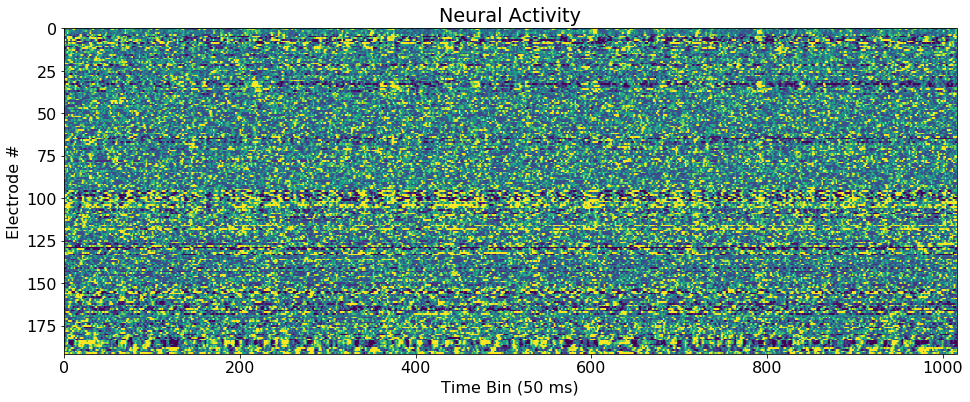

In [11]:
#Plot the neural activity that the HMM will process. 
plt.figure(figsize=(16,6))
plt.imshow(np.transpose(obs), aspect='auto', clim=[-0.5, 0.5])
plt.xlabel('Time Bin (50 ms)')
plt.ylabel('Electrode #')
plt.title('Neural Activity')
plt.show()

In [12]:
#Define the starting state probabilities for the HMM. The following gives a small chance of starting with a blank, or otherwise
#it begins with the first state of the first character.
startProb = np.zeros([A_hmm.shape[0]])
startProb[0] = blankProb
startProb[1] = 1 - startProb[0]

In [13]:
#For labeling long sentences, it can help to enforce that characters occur within a certain 
#time window defined by their lcoation in the sentence. This prevents pathological solutions 
#that place a large chunk of characters very close together. We implement this using 'probMask'.
#This mask is also used to enforce sentence termination (by allowing only the final states to occur at the last time step).

#During inference, 'probMask' is multiplied with the observation probabilities. 
#If it's zero for a given state and time step, then that state cannot appear at that time step.
probMask = np.zeros([obs.shape[0], A_hmm.shape[0]])

#Determine how big of a window we give each character, depending on sentence length
if len(sentence)==1:
    winLen = 1
elif len(sentence)<=10:
    winLen = 0.50
else:
    winLen = 0.30

#Now fill in probMask
for x in range(A_hmm.shape[0]):
    #first, get this state's character-level position in the sentence
    sl = stateLabelsSeq[x]
    
    #special logic for blank states (-1)
    if sl==-1:
        sl = stateLabelsSeq[x-1]
        
    #compute where this state should occur in normalized time
    timeFraction = sl/np.max(stateLabelsSeq)
        
    #compute the window of allowable time steps that this state can appear
    totalSteps = obs.shape[0]
    tIdx = np.arange(np.round(timeFraction*totalSteps - winLen*totalSteps),
                     np.round(timeFraction*totalSteps + winLen*totalSteps)).astype(np.int32)
    tIdx = tIdx[np.logical_and(tIdx>=0, tIdx<totalSteps)]
    
    probMask[tIdx, x] = 1
    
#sentence termination constraint (disallows all states at the last time step EXCEPT the final character state or blank)
probMask[-1, 0:-2] = 0

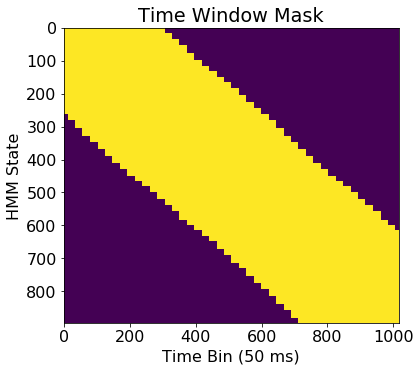

In [14]:
#Plot the probability mask (yellow region indicates band of accepted states for each time step)
plt.figure(figsize=(6,6))
plt.imshow(np.transpose(probMask))
plt.xlabel('Time Bin (50 ms)')
plt.ylabel('HMM State')
plt.title('Time Window Mask')
plt.show()

In [15]:
#Now do inference with the HMM using the forward-backward algorithm which gives, for each time step, the probability of each state
#occurring at that time step. 
#(see Chapter 13 of "Bishop, Christopher M. Pattern Recognition and Machine Learning. New York: Springer, 2011.")

#number of states in the HMM
numStates = A_hmm.shape[0] 

#number of time bins in the sentence plus one
L = obs.shape[0] + 1 

#For some sentences, the states don't propagate forward with high enough probability and don't reach the end of the sentence, 
#causing nans. To mitigate this issue, if we detect a failure, we relax the constraints by increasing the observation variance 
#and try again.
successfulCompletion = False

#with np.errstate(invalid='raise',divide='raise',over='raise'):
while not successfulCompletion:

    #Initialize the forward / backward probability vectors (fs, bs) and scaling factor (s).
    #fs = P(Xt | O1, ..., Ot)
    #bs ∝ P(Ot+1, ..., OT | Xt)
    #fs and bs are combined to compute P(Xt | O1, ... OT) ∝ P(Xt | O1, ..., Ot)P(Ot+1, ..., OT | Xt)

    fs = np.zeros([numStates, L])
    fs[:, 0] = startProb

    bs = np.ones([numStates, L])
    logBS = np.ones([numStates, L])

    s = np.zeros([L])
    s[0] = 1

    #forward pass
    for count in range(1, L):
        #multivariate normal observation probabilities P(Ot | Xt)
        squaredDiffTerm = -np.square(B_hmm-obs[count-1,:])/(2*diagVariance)
        gaussianEmissionProb = np.exp(np.sum(squaredDiffTerm, axis=1))

        #recursive computation of fs
        fs[:,count] = gaussianEmissionProb * np.matmul(np.transpose(A_hmm), fs[:,count-1]) * probMask[count-1,:]

        #scaling
        s[count] =  np.sum(fs[:,count])
        fs[:,count] =  fs[:,count]/s[count]   

    #backward pass
    for count in range(L-2,-1,-1):
        #multivariate normal observation probabilities P(Ot+1 | Xt+1)
        squaredDiffTerm = -np.square(B_hmm-obs[count,:])/(2*diagVariance)
        gaussianEmissionProb = np.exp(np.sum(squaredDiffTerm, axis=1))

        #recursive computation of bs
        bs[:,count] = np.matmul(A_hmm, bs[:,count+1] * gaussianEmissionProb * probMask[count,:])

        #scaling
        bs[:,count] = bs[:,count]/s[count+1]

    #final probabilities
    pSeq = np.sum(np.log(s))
    pStates = fs*bs

    #get rid of the first column
    pStates = pStates[:, 1:]

    if not np.any(np.isnan(pStates)):
        successfulCompletion = True
    else:
        #increase the variance a bit and try again
        print('Increasing variance to help states propagate to the end of the sentence.')
        diagVariance += 0.5

print('Forward-backward algorithm completed successfuly.')

Forward-backward algorithm completed successfuly.


/Users/aashnahari/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


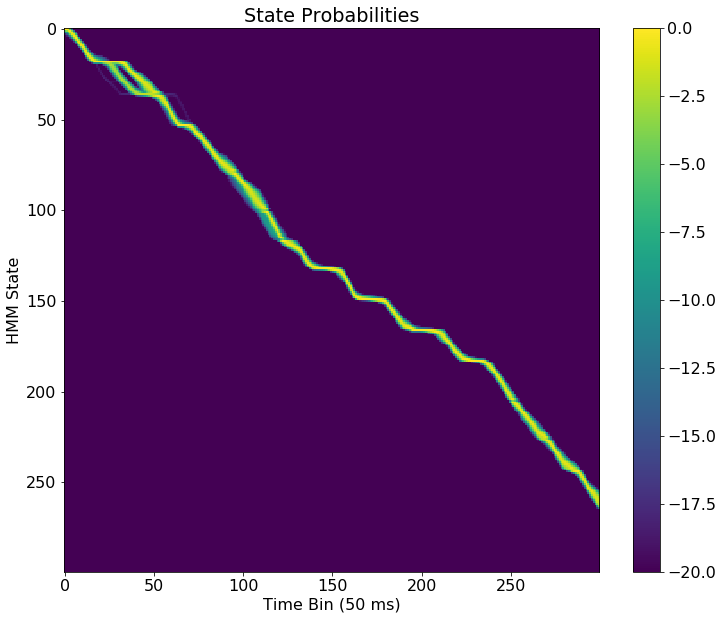

In [16]:
#Plot the log probabilities for each state over time. The path formed through the states shows an orderly progression through 
#the character sequence (as expected). Branches from the main path indicate alternative labelings.

#note that we convert negative infinity values into finite values for plotting (otherwise they appear white)
logProb = np.log(pStates[0:300, 0:300])
logProb[logProb==-np.inf] = -1000

plt.figure(figsize=(12,10))
plt.imshow(logProb,clim=[-20,0],aspect='auto')
plt.title('State Probabilities')
plt.xlabel('Time Bin (50 ms)')
plt.ylabel('HMM State')
plt.colorbar()
plt.show()

In [17]:
#The forward-backward algorithm gives state probabilities but not the most likely single sequence.
#We now use the Viterbi algorithm to find the most likely sequence of states, working with log probabilities
#to avoid numerical issues.

numStates = A_hmm.shape[0]
L = obs.shape[0]
logTR = np.log(A_hmm)

#pTR stores, for each state S and time step T, the previous state in the most likely path ending in S at time T.
#This can be used to backtrace the most likely path, beginning at the most likely state on the final time step. 
pTR = np.zeros([numStates,L])

#v stores, for each state, the probability of the most likely path that ends in that state.
v = np.log(startProb[:,np.newaxis])

#loop through each time step, updating pTR and v one step at a time
for count in range(L):
    #multivariate normal observation probabilities for this time step P(Ot | Xt)
    squaredDiffTerm = -np.square(B_hmm-obs[count,:])/(2*diagVariance)
    gaussianEmissionProb = np.sum(squaredDiffTerm, axis=1, keepdims=True)

    #recursively update v; for each state, find the best way to get there from the previous time step
    #and keep track of it in pTR
    tmpV = v + logTR
    maxIdx = np.argmax(tmpV, axis=0)
    maxVal = np.take_along_axis(tmpV, np.expand_dims(maxIdx, axis=0), axis=0)

    v = gaussianEmissionProb + np.transpose(maxVal) + np.log(probMask[count,:,np.newaxis])
    pTR[:,count] = maxIdx

#decide which of the final states is most probable
finalState = np.argmax(v)
logP = v[finalState]

#Now back trace through pTR to get the most likely state path
viterbiStates = np.zeros([L]).astype(np.int32)
viterbiStates[-1] = finalState
for count in range(L-2,0,-1):
    viterbiStates[count] = pTR[viterbiStates[count+1], count+1]
    

/Users/aashnahari/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/Users/aashnahari/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  
/Users/aashnahari/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log


/Users/aashnahari/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


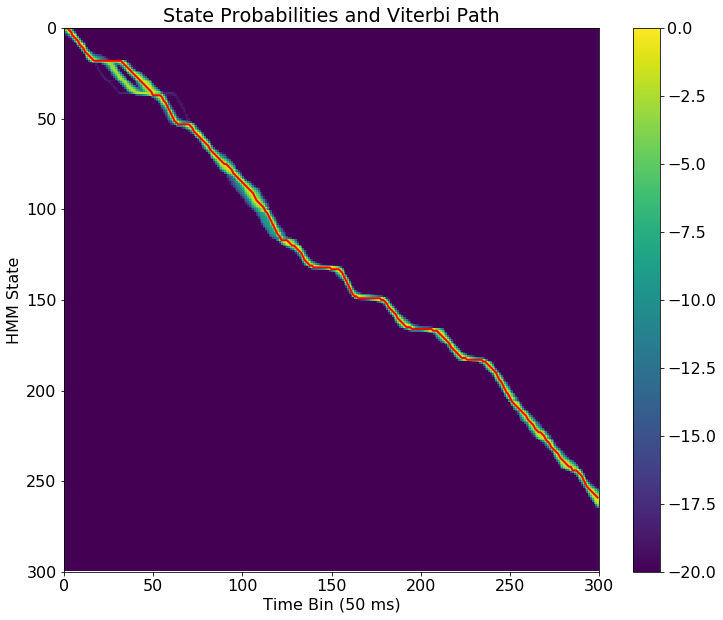

In [18]:
#Plot the Viterbi sequence of states with a red trace on top of the state probabilities.
logProb = np.log(pStates[0:300, 0:300])
logProb[logProb==-np.inf] = -1000

plt.figure(figsize=(12,10))
plt.imshow(logProb, clim=[-20,0], aspect='auto')
plt.plot(np.arange(0,300), viterbiStates[0:300],'-r',linewidth=2)
plt.xlim([0,300])
plt.ylim([0,300])

plt.xlabel('Time Bin (50 ms)')
plt.ylabel('HMM State')
plt.title('State Probabilities and Viterbi Path')

plt.colorbar()
plt.gca().invert_yaxis()
plt.show()

In [19]:
#Get  character start times and character stretch factors from the Viterbi sequence of HMM states.
labeledStates = stateLabelsSeq[viterbiStates]

letterStarts = np.zeros([len(sentence),1])
letterStretches = np.zeros([len(sentence),1])
for x in range(len(sentence)):
    thisChar = np.argwhere(labeledStates[:,0]==x)
    letterStarts[x] = (thisChar[0]+1)*hmmBinSize-1
    letterStretches[x] = (len(thisChar)*hmmBinSize)/templates[sentence[x]].shape[0]

In [20]:
#In this next step, we refine the start times of each character by shifting them around a bit 
#until they lie on correlation hotspots
for c in range(len(sentence)):
    #generate a list of potential start times for this character
    possibleStart = np.arange(letterStarts[c]-50, letterStarts[c]+55, 5).astype(np.int32)
    possibleStart = possibleStart[possibleStart>=0]
    
    #don't allow start times that are too close to the previous character
    if c>0:
        possibleStart = possibleStart[possibleStart>=(letterStarts[c-1]+20)]
        
    possibleStretch = np.linspace(0.4, 1.5, 15)
    template = templates[sentence[c]]
    
    corrHeatmap = np.zeros([len(possibleStretch), len(possibleStart)])
    corrHeatmap[:] = -np.inf
    
    #compute correlation heatmap by correlating the template to the data at each stretch factor and start location
    for (stretch, stretchCount) in zip(possibleStretch, range(len(possibleStretch))):
        newX = np.linspace(0,1,int(np.round(template.shape[0]*stretch)))
        stretchedTemplate = np.zeros([len(newX), template.shape[1]])
        for colIdx in range(template.shape[1]):
            stretchedTemplate[:,colIdx] = np.interp(newX, np.linspace(0,1,template.shape[0]), template[:,colIdx])
            
        for (startIdx, startCount) in zip(possibleStart, range(len(possibleStart))):
            #don't evaluate possibilities that intersect the previous template
            if c>0:
                prevTemplateEnd = letterStarts[c-1] + letterStretches[c-1]*templates[sentence[c-1]].shape[0]
                if startIdx < (prevTemplateEnd-10):
                    continue
            
            #don't evaluate possibilities that intersect the next template
            if c<len(sentence)-1:
                thisTemplateEnd = startIdx + stretchedTemplate.shape[0]
                if thisTemplateEnd > letterStarts[c+1]+10:
                    continue
                    
            #don't evaluate possibilities that lie outside of the data range
            stepIdx = np.arange(startIdx, startIdx + stretchedTemplate.shape[0]).astype(np.int32)
            if stepIdx[-1]>=(obsRaw.shape[0]):
                continue
                
            #compute correlation between this template and the data
            msDat = obsRaw[stepIdx,:] - np.mean(obsRaw[stepIdx,:], axis=0, keepdims=True)
            msST = stretchedTemplate - np.mean(stretchedTemplate, axis=0, keepdims=True)
            
            normDat = np.sqrt(np.sum(np.square(msDat), axis=0))
            normST = np.sqrt(np.sum(np.square(msST), axis=0))
                            
            corrCoeff = np.sum(msDat * msST, axis=0) / (normDat * normST)
            corrHeatmap[stretchCount, startCount] = np.nanmean(corrCoeff)

    #select character stretch factors and start times based on the heatmap hotspot
    maxIdx = np.argmax(corrHeatmap)
    maxIdx = np.unravel_index(maxIdx, corrHeatmap.shape)
    
    letterStretches[c] = possibleStretch[maxIdx[0]]
    letterStarts[c] = possibleStart[maxIdx[1]]

/Users/aashnahari/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in true_divide


In [22]:
#Finally, we make character heatmaps to validate successful labeling. This is just a qualitative way to visualize what's
#going on (i.e. it's a useful sanity check). The heatmaps are made by correlating a character template to the data with
#different start times and contraction/dilation of the template. If the HMM labeling process worked well, the 
#inferred character start times should lie on a hotspot. They often do, but not always.
heatmapList = []

for x in range(len(sentence)):
    possibleStart = np.arange(letterStarts[x]-200, letterStarts[x]+200, 10).astype(np.int32)
    possibleStretch = np.linspace(0.4,1.5,15);
    thisTemplate = templates[sentence[x]]
    
    corrHeatmap = np.zeros([len(possibleStretch), len(possibleStart)])

    for (stretch, stretchCount) in zip(possibleStretch, range(len(possibleStretch))):
        #make new dilated/contracted template
        newX = np.linspace(0,1,int(thisTemplate.shape[0]*stretch))
        stretchedTemplate = np.zeros([len(newX), thisTemplate.shape[1]])
        for colIdx in range(thisTemplate.shape[1]):
            stretchedTemplate[:,colIdx] = np.interp(newX, np.linspace(0,1,thisTemplate.shape[0]), thisTemplate[:,colIdx])
            
        for (startIdx, startCount) in zip(possibleStart, range(len(possibleStart))):
            #check if template falls oustide of the data boundaries
            if startIdx < 0:
                continue
            if startIdx + stretchedTemplate.shape[0] >= obsRaw.shape[0]:
                continue
                
            #compute correlation between this template and the data
            stepIdx = np.arange(startIdx, startIdx+stretchedTemplate.shape[0]).astype(np.int32)
            
            msDat = obsRaw[stepIdx,:] - np.mean(obsRaw[stepIdx,:], axis=0, keepdims=True)
            msST = stretchedTemplate - np.mean(stretchedTemplate, axis=0, keepdims=True)
            
            normDat = np.sqrt(np.sum(np.square(msDat), axis=0))
            normST = np.sqrt(np.sum(np.square(msST), axis=0))
            
            corrCoeff = np.sum(msDat * msST, axis=0) / (normDat * normST)
            corrHeatmap[stretchCount, startCount] = np.nanmean(corrCoeff)
            
    heatmapList.append(corrHeatmap)


/Users/aashnahari/opt/anaconda3/envs/tf-py3.6-1.15.0/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


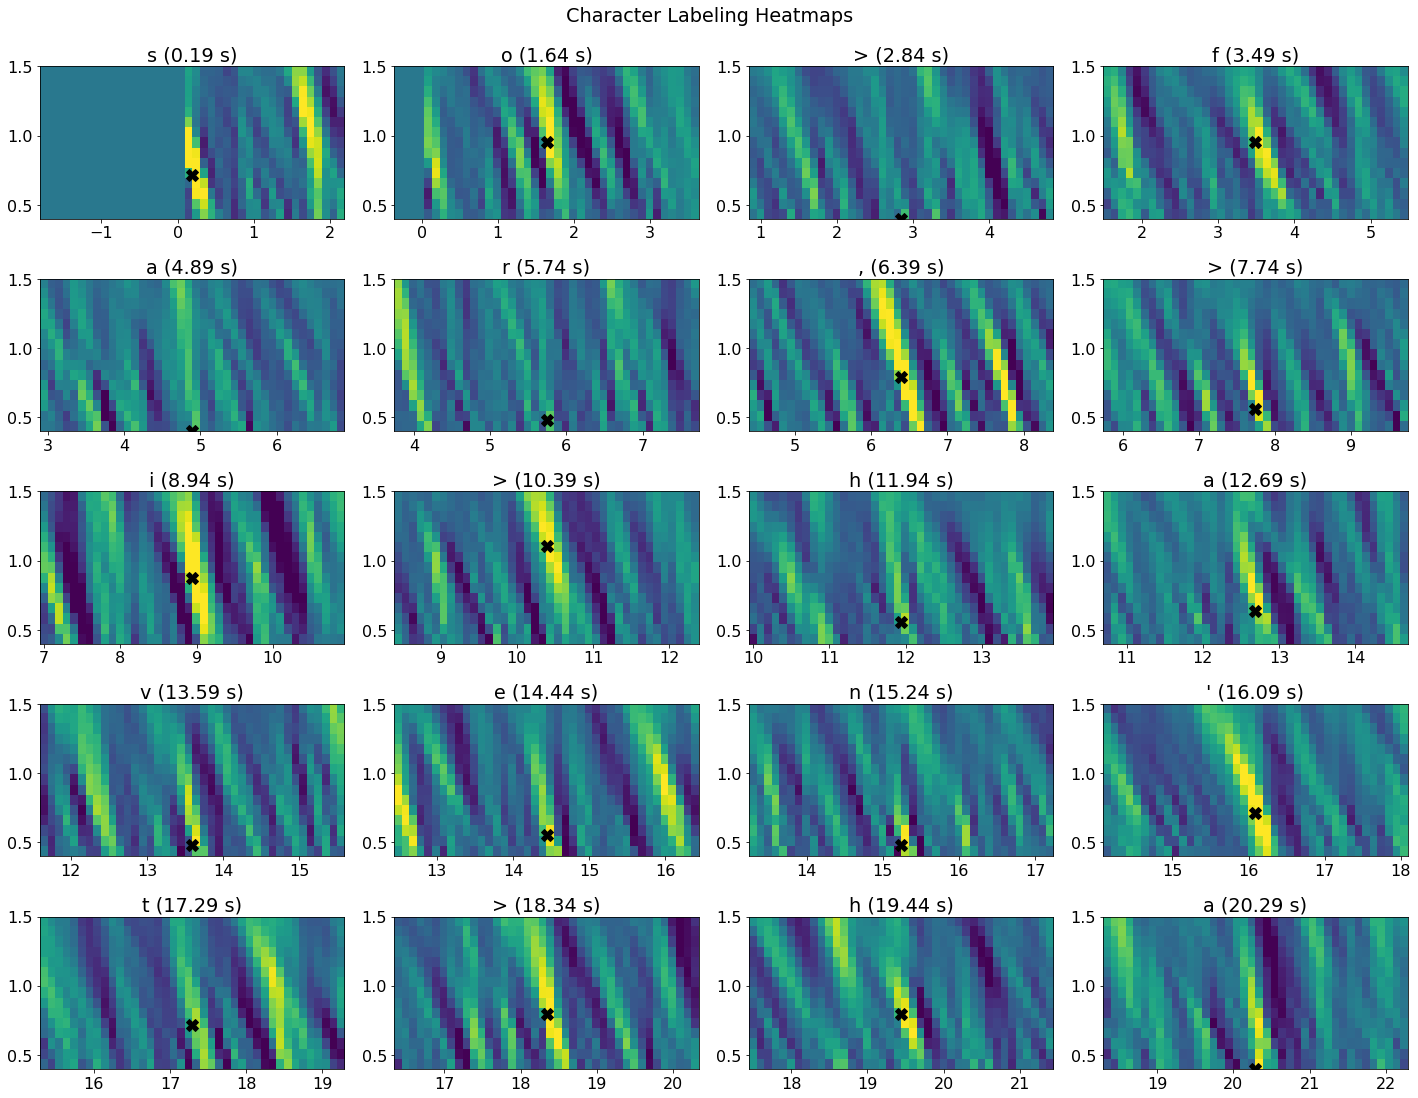

In [23]:
#Plot the heatmaps generated above for the first 16 characters of the sentence. For each heatmap, the x-axis is time (in seconds)
#and the y-axis is the 'stretch factor' (linear time dilation/contraction)
plt.rcParams.update({'font.size': 16})

plotIdx = np.arange(0, 20).astype(np.int32)

plt.figure(figsize=(20,15))
for p in range(len(plotIdx)):
    plt.subplot(5,4,p+1)
    
    x = plotIdx[p]
    plt.imshow(heatmapList[x], aspect='auto', clim=[-0.1, 0.15], 
               extent=[letterStarts[x]/100-2, letterStarts[x]/100+2, 1.5, 0.4])
    
    plt.plot(letterStarts[x]/100, letterStretches[x],'kX',markersize=12)

    plt.gca().invert_yaxis()
    plt.title(sentence[x] + ' (' + str(letterStarts[x,0]/100) + ' s)')
    
plt.gcf().suptitle('Character Labeling Heatmaps',y=1.02)
plt.gcf().tight_layout()
plt.show()

In [24]:
#Finally, we construct the time series 'targets' used to train the RNN. The RNN is trained using supervised learning to 
#produce the following two outputs: a character probability vector with a one-hot encoding of the current character, 
#and a binary'new character' signal which briefly goes high at the start of any new character. 

#Note that we also produce an 'ignoreError' vector which describes, for each time step, whether the cost function should ignore
#any errors at that time step. We use this feature to prevent the RNN from being pnealized for errors that occur at the very
#start of the trial, before T5 has written any character yet (if the HMM has labeled this as a 'blank' state).

charProbTarget = np.zeros([obsRaw.shape[0], len(charDef['charList'])])
charStartTarget = np.zeros([obsRaw.shape[0], 1])
ignoreErrorHere = np.zeros([obsRaw.shape[0], 1])

for x in range(len(sentence)):
    #(1) one-hot encoding of the 'current' (or most recently started) character
    
    #first get the time steps to fill
    if x<(len(sentence)-1):
        #not the last character - extend until next character
        stepIdx = np.arange(letterStarts[x], letterStarts[x+1]).astype(np.int32)
    else:
        #last character - extend until end of sentence
        stepIdx = np.arange(letterStarts[x], obsRaw.shape[0]).astype(np.int32)
        
    #now fill in these time steps with a '1' for the given character
    charIdx = np.squeeze(np.argwhere(np.array(charDef['charListAbbr'])==sentence[x]))
    charProbTarget[stepIdx, charIdx] = 1
    
    #(2) character start signal that goes high for the first 200 ms of each new character
    stepIdx = np.arange(letterStarts[x], letterStarts[x]+21).astype(np.int32)
    charStartTarget[stepIdx] = 1
        
#Finally, we fill in the very beginning (which could be a blank) with the first character.
#Also, we mark this time period as something to be 'ignored', since there is no way for the RNN to correctly
#guess that these time steps belong to this character (because is hasn't been written yet).

charIdx = np.squeeze(np.argwhere(np.array(charDef['charListAbbr'])==sentence[0]))
charProbTarget[0:letterStarts[0,0].astype(np.int32), charIdx] = 1
ignoreErrorHere[0:letterStarts[0,0].astype(np.int32)] = 1

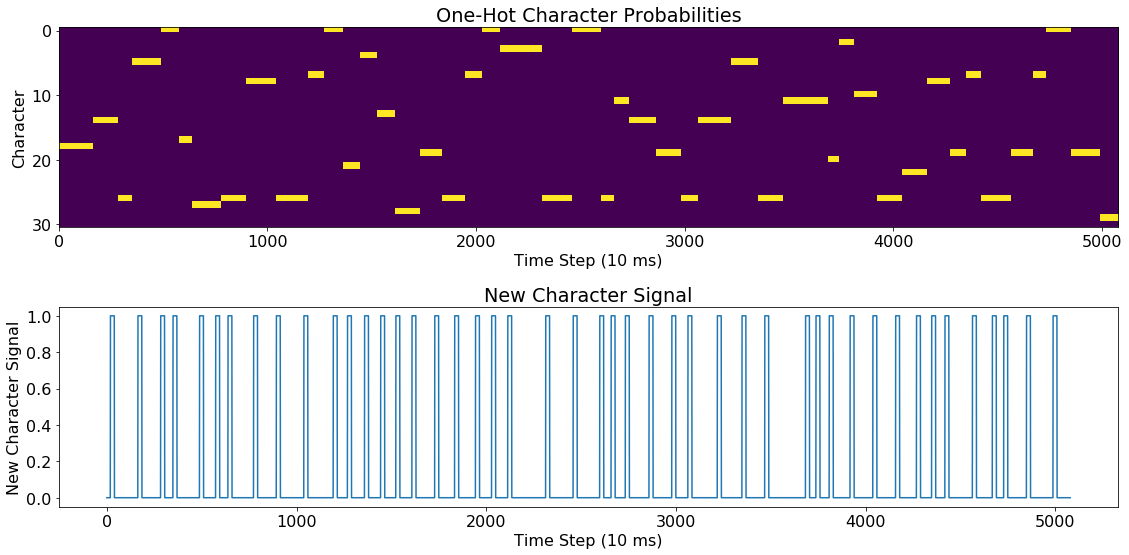

In [25]:
#Plot the RNN targets for this sentence
plt.figure(figsize=(16,8))

plt.subplot(2,1,1)
plt.imshow(np.transpose(charProbTarget), aspect='auto')
plt.xlabel('Time Step (10 ms)')
plt.ylabel('Character')
plt.title('One-Hot Character Probabilities')

plt.subplot(2,1,2)
plt.plot(charStartTarget)
plt.xlabel('Time Step (10 ms)')
plt.ylabel('New Character Signal')
plt.title('New Character Signal')

plt.gcf().tight_layout()
plt.show()

In [29]:
#And that's it!

#Note that this walkthrough does NOT include an iterative step that updates the HMM parameters after labeling
#(and then re-labels the data based on these updated parameters). 

#See 'Step2_hmmLabeler_automated.ipynb' for a complete, automated implementation of the HMM data labeling step. 
#Step2_hmmLabeler_automated.ipynb can be run to label all data from all sessions.